In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import nibabel as nib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from reload_recursive import reload_recursive
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from matplotlib import colormaps
import sys
import re
from scipy import stats

from mri_data import file_manager as fm

sys.path.append("/home/srs-9/Projects/ms_mri/analysis/paper1")

import helpers

### Paths and Config

In [ ]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
cp_data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
dataroot = Path("/media/smbshare/srs-9/thalamus_project/data")

showfigs = False
pd.options.display.precision = 3
subject_sessions = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/subject-sessions.csv", index_col="sub")

viridis = colormaps['viridis'].resampled(20)

In [74]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")


new_index = []
for col in df_thomas.columns:
    new_index.append(int(re.match(r".+_(\d+)$", col)[1]))

df_structs = pd.DataFrame({'struct': df_thomas.columns}, index=new_index)
ind_struct_lookup = {}
for i, row in df_structs.iterrows():
    ind_struct_lookup[i] = row['struct']
struct_ind_lookup = {}
for i, row in df_structs.iterrows():
    struct_ind_lookup[row['struct']] = i

thalamic_nuclei = df_thomas.columns[1:11]
thalamic_nuclei_inds = [struct_ind_lookup[struct] for struct in thalamic_nuclei]

In [16]:
df_dists = pd.read_csv(data_dir / "centroid-SDT.csv", index_col="subid")

dist_colnames = {}
for k,v in ind_struct_lookup.items():
    dist_colnames[k] = f"{v}_dist"
df_dists = df_dists.rename(columns=dist_colnames)
df_dists_z = df_dists.apply(stats.zscore, nan_policy="omit")

In [79]:
df = pd.read_csv(cp_data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(cp_data_dir / "t1_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df = helpers.set_dz_type5(df)
df = helpers.fix_edss(df)
df = df.rename(columns={"extracted_EDSS": "EDSS"})
df = helpers.do_sqrt_transform(df, ["EDSS"])

numeric_vars = ["choroid_volume", "pineal_volume", "pituitary_volume", "Female", "age", "tiv", "EDSS", "EDSS_sqrt"]
keep_cols = numeric_vars + ["dz_type5"]
df = df[keep_cols]
df_z = df.copy()
df_z[numeric_vars] = df[numeric_vars].apply(stats.zscore, nan_policy="omit")

Outcome: choroid

thalamic nuclei

Text(0.5, 1.0, 'EDSS ~ struct + covars')

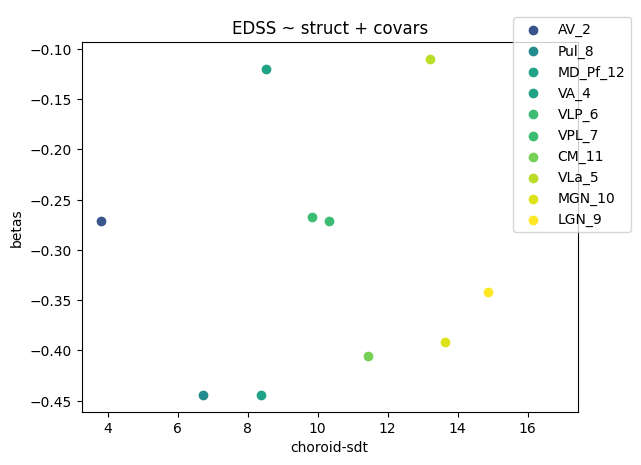

In [171]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

outcome = "choroid_volume"

structs = thalamic_nuclei
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

# print(regression_results)

df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])


xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+2])
fig.legend(loc=(0.8,0.5))


axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")

Outcome: EDSS  

All structures

Text(4, 0, 'R2=0.16\np=0.09')

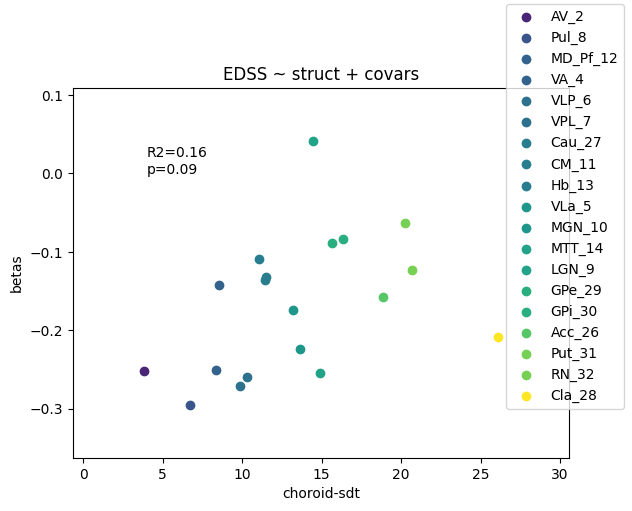

In [160]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

outcome = "EDSS_sqrt"

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

# print(regression_results)

df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])

axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")
axes.margins(0.2)
fig.legend(loc=(0.8,0.2))

slope, intercept, r_value, p_value, std_err = stats.linregress(df_summary['dist'], df_summary['coef'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, 0, text)

Outcome: EDSS  

All structures except claustrum

Text(4, 0, 'R2=0.32\np=0.01')

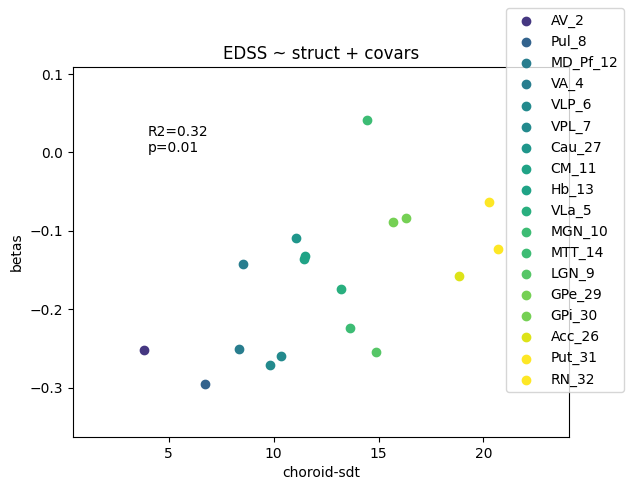

In [159]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

outcome = "EDSS_sqrt"

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
all_results = {}
for struct in structs:
    formula = f"{outcome} ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

# print(regression_results)

df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()


df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], color=viridis(c), label=df_summary.loc[i, 'struct'])

axes.set_xlabel("choroid-sdt")
axes.set_ylabel("betas")
axes.set_title("EDSS ~ struct + covars")
axes.margins(0.2)
fig.legend(loc=(0.8,0.2))

slope, intercept, r_value, p_value, std_err = stats.linregress(df_summary['dist'], df_summary['coef'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, 0, text)

In [ ]:
text = "{:0.2f}\n{:0.2f}".format(r_value, p_value)
print(text)

0.08917589345058728

In [96]:
model_data = df_z.join([df_thomas_z, df_dists_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

# structs = thalamic_nuclei
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
all_results = {}
for struct in structs:
    formula = f"{struct} ~ EDSS_sqrt + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues['EDSS_sqrt']
    coefs[struct] = res.params['EDSS_sqrt']
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.286  4.118e-09  7.824e-08    -0.286
9      LGN_9 -0.280  7.704e-08  7.319e-07    -0.280
12  MD_Pf_12 -0.246  5.764e-07  2.332e-06    -0.246
7      VPL_7 -0.243  4.301e-07  2.332e-06    -0.243
6      VLP_6 -0.227  6.138e-07  2.332e-06    -0.227
2       AV_2 -0.220  2.272e-06  7.193e-06    -0.220
10    MGN_10 -0.200  2.221e-05  6.027e-05    -0.200
28    Cla_28 -0.171  1.635e-04  3.884e-04    -0.171
13     Hb_13 -0.152  4.908e-03  8.478e-03    -0.152
5      VLa_5 -0.137  2.093e-03  4.419e-03    -0.137
26    Acc_26 -0.132  4.197e-03  7.974e-03    -0.132
11     CM_11 -0.122  1.052e-02  1.665e-02    -0.122
4       VA_4 -0.104  1.601e-02  2.339e-02    -0.104
32     RN_32 -0.092  3.499e-02  4.748e-02    -0.092
27    Cau_27 -0.089  5.109e-02  6.472e-02     0.000
29    GPe_29 -0.066  1.300e-01  1.544e-01     0.000
30    GPi_30 -0.065  1.435e-01  1.603e-01     0.000
31    Put_31 -0.045  2.937e-01  3.100e-01     0.000
14    MTT_14

In [109]:
df_summary = regression_results.copy()
for i in df_summary.index:
    df_summary.loc[i, 'dist'] = df_dists[f"{ind_struct_lookup[i]}_dist"].mean()

df_summary['colors'] = list(np.random.choice(range(256), size=(len(df_summary), 3)) / 255)

/tmp/ipykernel_700599/341764750.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], c=viridis(c), label=df_summary.loc[i, 'struct'])


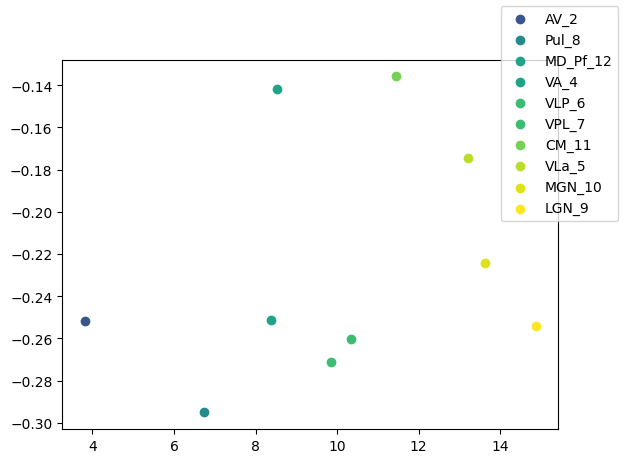

In [110]:
viridis = colormaps['viridis'].resampled(20)
df_summary = df_summary.sort_values(by="dist")
fig, axes = plt.subplots(1)
for i, row in df_summary.iterrows():
    c = df_summary.loc[i, 'dist'] / df_summary['dist'].max()
    axes.scatter(df_summary.loc[i, 'dist'], df_summary.loc[i, 'coef'], c=viridis(c), label=df_summary.loc[i, 'struct'])
fig.legend(loc='outside upper right')

In [75]:
sub = 1001
subdir = dataroot / f"sub{sub}-{subject_sessions.loc[sub, 'ses']}"
thomL_img = nib.load(subdir / "thomasfull_L.nii.gz")
affine = thomL_img.affine
thomL = thomL_img.get_fdata()
thomR = nib.load(subdir / "thomasfull_R.nii.gz").get_fdata()
thom = thomL + thomR
thom[~np.isin(thom, thalamic_nuclei_inds)] = 0
for struct in thalamic_nuclei:
    colname = struct + "_dist"
    dist = df_dists.loc[sub, colname]
    i = struct_ind_lookup[struct]
    thom[thom==i] = dist

thom_img = nib.Nifti1Image(thom, affine)
nib.save(thom_img, subdir/"thalamic_nuclei-choroid_sdt-map.nii.gz")

In [77]:
np.unique(thom)

array([ 0.        ,  3.2984848 ,  7.33213806,  7.95990133,  8.23650455,
        9.15643978, 10.27619839, 11.22853851, 11.8118906 , 15.45057011,
       17.60000801])